In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# image libraries
import cv2

In [2]:
tf.keras.__version__

'2.10.0'

In [3]:
# directories
# train_img_path = '/kaggle/input/cifake-real-and-ai-generated-synthetic-images/train'
# test_img_path = '/kaggle/input/cifake-real-and-ai-generated-synthetic-images/test'

train_img_path = 'artifact/train'
test_img_path = 'artifact/test'

w,h = 200,200
batch_size = 32

train_data_gen = ImageDataGenerator(
    rescale = 1.0/255
)
test_data_gen = ImageDataGenerator(rescale = 1.0/255)

train_Dataset = train_data_gen.flow_from_directory(
    train_img_path,
    target_size = (w,h),
    batch_size = batch_size,
    class_mode = 'binary',
    shuffle = True
)

test_Dataset = test_data_gen.flow_from_directory(
    test_img_path,
    target_size = (w,h),
    batch_size = batch_size,
    class_mode = 'binary',
    shuffle = False
)

Found 882752 images belonging to 2 classes.
Found 220694 images belonging to 2 classes.


In [4]:
train_Dataset.class_indices

{'FAKE': 0, 'REAL': 1}

In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# ResNET Transfer learning


In [6]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Load pre-trained ResNet50 model without the top (classification) layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(200, 200, 3))

# Create a new model on top
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')  # Output layer with 1 neuron (binary classification)
])

# Freeze the base model layers 
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 24,112,513
Trainable params: 524,801
Non-trainable params: 23,587,712
_________________________________________________________________


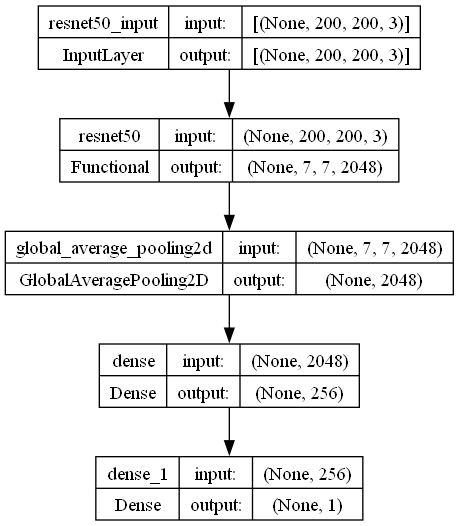

In [8]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True)

In [9]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [10]:
fake_number = 363839
real_number = 518913
total = fake_number + real_number

weight_for_0 = (1 / fake_number) * (total / 2.0)
weight_for_1 = (1 / real_number) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.21
Weight for class 1: 0.85


In [11]:
# Train the model
history = model.fit(train_Dataset, 
                    epochs=10, 
                    # callbacks=[model_checkpoint],
                    class_weight=class_weight)

Epoch 1/10
27586/27586 [==============================] - 1019s 37ms/step - loss: 0.6418 - accuracy: 0.6083
Epoch 2/10
27586/27586 [==============================] - 927s 34ms/step - loss: 0.6281 - accuracy: 0.6254
Epoch 3/10
27586/27586 [==============================] - 908s 33ms/step - loss: 0.6238 - accuracy: 0.6301
Epoch 4/10
27586/27586 [==============================] - 829s 30ms/step - loss: 0.6215 - accuracy: 0.6327
Epoch 5/10
27586/27586 [==============================] - 818s 30ms/step - loss: 0.6194 - accuracy: 0.6352
Epoch 6/10
27586/27586 [==============================] - 818s 30ms/step - loss: 0.6177 - accuracy: 0.6369
Epoch 7/10
27586/27586 [==============================] - 889s 32ms/step - loss: 0.6165 - accuracy: 0.6357
Epoch 8/10
27586/27586 [==============================] - 848s 31ms/step - loss: 0.6157 - accuracy: 0.6353
Epoch 9/10
27586/27586 [==============================] - 851s 31ms/step - loss: 0.6147 - accuracy: 0.6379
Epoch 10/10
27586/27586 [===========

In [12]:
model.save_weights('./checkpoints/my_checkpoint_resnet_databal')
model.save('my_model_resnet_databal.keras')
model.save('my_model_resnet_databal.h5')

In [13]:
# load best weights to model
# model.load_weights(weight_path)
from sklearn.metrics import accuracy_score

# make prediction
predictions = model.predict(test_Dataset)
binary_predictions = (predictions > 0.5).astype(int)

accuracy = accuracy_score(test_Dataset.classes, binary_predictions)
print(f'Accuracy: {accuracy*100:.2f}%')


6897/6897 [==============================] - 261s 38ms/step
Accuracy: 63.10%


In [14]:
from sklearn.metrics import confusion_matrix, classification_report

# Assuming you have true labels (ground truth)
true_labels = test_Dataset.classes

# Generate a confusion matrix
# sns.heatmap(confusion_matrix(true_labels, binary_predictions), annot=True)

# Print classification report
print(classification_report(true_labels, binary_predictions))

# plt.title('Confusion Matrix')
# plt.xlabel('Predicted')
# plt.ylabel('Actual Classes')
# plt.show()

              precision    recall  f1-score   support

           0       0.54      0.72      0.62     90962
           1       0.74      0.57      0.64    129732

    accuracy                           0.63    220694
   macro avg       0.64      0.64      0.63    220694
weighted avg       0.66      0.63      0.63    220694

